In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import imdb

### Hyperparameters
#### Epoch: 10
#### Initial Learning Rate: 1e-3
#### Batch  Size: 512
#### Kernel Initializer: Orthogonal(default)


In [0]:
max_features = 10000
maxlen = 400
epoch = 10
learning_rate = 1e-3
batch = 512
initializer = initializers.Orthogonal(seed=114)
cnn_initializer = initializers.glorot_uniform(seed=114)
use_cudnn = True
use_regulizar = False

### 決定是否使用GPU加速訓練 :
#### 如果條件符合，Tensorflow可以使用GPU加速訓練CuDnnLSTM、CuDnnGRU
#### 條件之一為 recurrent_dropout == 0

In [0]:
if(use_cudnn):
  recurrent_dropout = 0
else:
  recurrent_dropout = 0.5

### 決定是否使用 kernel_regulizar :
#### 能夠某種程度上抑止過擬合
#### 使用L2正則化


In [0]:
if(use_regulizar):
  regularizer = regularizers.l2(0.05)
else:
  regularizer = None

In [0]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

### 定義 cnn_layer :
#### 先加入一層 Layer Normalization
#### 加入 1D 卷積層
#### 加入 Dropout，使用 1D Spatial Dropout 
#### 加入 ELU Activation Function

In [0]:
def cnn_layer(units, dropoutrate = 0):
    layer = models.Sequential()
    layer.add(LayerNormalization())
    layer.add(Conv1D(filters=units, kernel_size=1, kernel_initializer=cnn_initializer, strides=1, padding='same'))
    if(dropoutrate>0):
        layer.add(SpatialDropout1D(dropoutrate))
    layer.add(layers.Activation('elu'))
    return layer

### 定義 rnn_layer :
#### 先加入一層 Layer Normalization
#### 決定使用哪種雙向 RNN Block(default GRU)
#### 加入輸出 Dropout，使用 1D Spatial Dropout 
#### 加入 ELU Activation Function

In [0]:
def rnn_layer(units, recurrent_dropout,dropout=0.5, dropoutrate = 0, rnn = 'GRU'):
    layer = models.Sequential()
    layer.add(LayerNormalization())
    if(rnn == 'GRU'):
      layer.add(Bidirectional(GRU(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    elif(rnn == 'LSTM'):
      layer.add(Bidirectional(LSTM(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    else:
      layer.add(Bidirectional(RNN(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    if(dropoutrate>0):
        layer.add(SpatialDropout1D(dropoutrate))
    layer.add(layers.Activation('elu'))
    return layer

### 定義網路架構 :
#### 使用 CNN+GRU結構訓練
#### GRU部分採金字塔狀結構設計

In [9]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(cnn_layer(256, 0.25))
model.add(rnn_layer(256, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(128, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(64, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(32, recurrent_dropout, 0.5, 0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 128)          1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 128)          0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 400, 256)          33280     
_________________________________________________________________
sequential_2 (Sequential)    (None, 400, 512)          790016    
_________________________________________________________________
sequential_3 (Sequential)    (None, 400, 256)          494080    
_________________________________________________________________
sequential_4 (Sequential)    (None, 400, 128)          124160    
_________________________________________________________________
sequential_5 (Sequential)    (None, 400, 64)           3

#### Optimizer : Adam，使用了clipvalue防止梯度爆炸
#### Train : Validation : Test = 4 : 1 : 5
#### 由於網路過擬合速度與程度都過快，所以 early_stop patience設比較短


In [10]:
adam = optimizers.Adam(lr = learning_rate, clipvalue=0.5)
model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=2)
history = model.fit(x_train,
                    y_train, 
                    batch_size=batch, 
                    epochs=epoch,
                    validation_split = (1/5),
                    # verbose=1, 
                    callbacks=[early_stop]
                    )  

Epoch 1/10
40/40 [==============================] - 52s 1s/step - loss: 0.7224 - accuracy: 0.5012 - val_loss: 0.6913 - val_accuracy: 0.5280
Epoch 2/10
40/40 [==============================] - 50s 1s/step - loss: 0.6743 - accuracy: 0.5609 - val_loss: 0.4944 - val_accuracy: 0.7870
Epoch 3/10
40/40 [==============================] - 50s 1s/step - loss: 0.4080 - accuracy: 0.8334 - val_loss: 0.2942 - val_accuracy: 0.8821
Epoch 4/10
40/40 [==============================] - 50s 1s/step - loss: 0.2404 - accuracy: 0.9112 - val_loss: 0.2673 - val_accuracy: 0.8963
Epoch 5/10
40/40 [==============================] - 50s 1s/step - loss: 0.1674 - accuracy: 0.9401 - val_loss: 0.3093 - val_accuracy: 0.8838
Epoch 00005: early stopping


In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

782/782 - 52s - loss: 0.3227 - accuracy: 0.8795


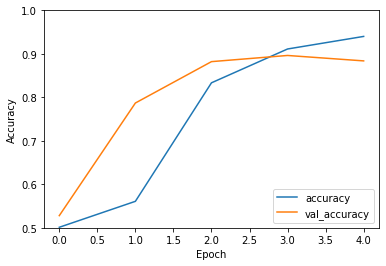

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# plt.savefig("ann_acc.png", dpi=500)

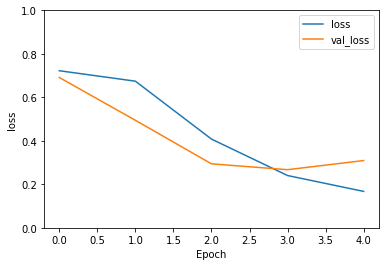

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
# plt.savefig("ann_loss.png", dpi=500)

##Result : 
### Train accuracy: 94.01%
### Valid accuracy: 88.38%
### Test  accuracy: 87.95%


### 使用 recurrent_dropout 訓練
#### 會OOM所以降低了 Batch_size


In [0]:
max_features = 10000
maxlen = 400
epoch = 10
learning_rate = 1e-3
batch = 128
initializer = initializers.Orthogonal(seed=114)
use_cudnn = False
use_regulizar = False

In [0]:
if(use_cudnn):
  recurrent_dropout = 0
else:
  recurrent_dropout = 0.5

In [0]:
if(use_regulizar):
  regularizer = regularizers.l2(0.05)
else:
  regularizer = None

In [22]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(cnn_layer(256, 0.25))
model.add(rnn_layer(256, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(128, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(64, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(32, recurrent_dropout, 0.5, 0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 400, 128)          0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 400, 256)          33280     
_________________________________________________________________
sequential_14 (Sequential)   (None, 400, 512)          790016    
_________________________________________________________________
sequential_15 (Sequential)   (None, 400, 256)          494080    
_________________________________________________________________
sequential_16 (Sequential)   (None, 400, 128)          124160    
_________________________________________________________________
sequential_17 (Sequential)   (None, 400, 64)         

In [23]:
adam = optimizers.Adam(lr = learning_rate, clipvalue=0.5)
model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=2)
history = model.fit(x_train,
                    y_train, 
                    batch_size=batch, 
                    epochs=epoch,
                    validation_split = (1/5),
                    # verbose=1, 
                    callbacks=[early_stop]
                    )  

Epoch 1/10
157/157 [==============================] - 1698s 11s/step - loss: 0.6929 - accuracy: 0.5385 - val_loss: 0.4463 - val_accuracy: 0.8073
Epoch 2/10
157/157 [==============================] - 1566s 10s/step - loss: 0.3425 - accuracy: 0.8598 - val_loss: 0.2791 - val_accuracy: 0.8845
Epoch 3/10
157/157 [==============================] - 1538s 10s/step - loss: 0.2024 - accuracy: 0.9252 - val_loss: 0.2580 - val_accuracy: 0.8930
Epoch 4/10
157/157 [==============================] - 1523s 10s/step - loss: 0.1458 - accuracy: 0.9487 - val_loss: 0.2606 - val_accuracy: 0.8918
Epoch 00004: early stopping


In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

782/782 - 533s - loss: 0.2950 - accuracy: 0.8785


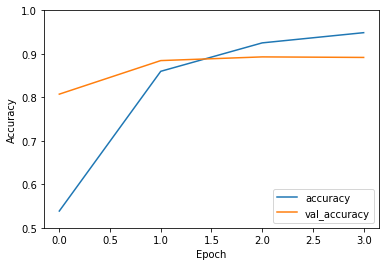

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# plt.savefig("ann_acc.png", dpi=500)

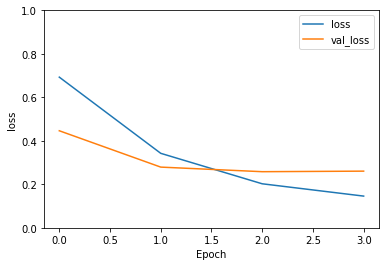

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
# plt.savefig("ann_loss.png", dpi=500)

##Result : 
### Train accuracy: 94.87%
### Valid accuracy: 89.18%
### Test  accuracy: 87.85%
